# Rice grains segmentation
Objectives of this notebook :
1) segmentation of garins (adaptive theresholding --> morphological operations (erosion + dilation) --> Distance transform --> Sure foreground / sure background
--> Markers before watershed --> and watershed algorithm to separate touching grains)
2) coloring each grain using markers and labels
3) Calculating **area and aspect ratio** for each grain
4) Displaying area and aspect ratio as hover text on the centroids of grains.
5) Plotting **histograms and cumulative histograms** of grain areas
6) test reproducibility --> I applied my segmentation pipeline to a new image created by rotating the original rice-grain image by 180 degrees.




In [216]:
import numpy as np
import cv2

In [217]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


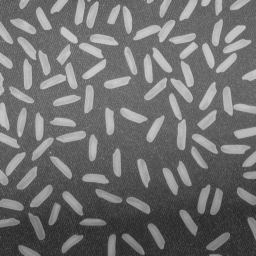

In [218]:
from google.colab.patches import cv2_imshow
img_path = '/content/drive/MyDrive/rice.png'
img = cv2.imread(img_path)
cv2_imshow(img)

## Discription of the image and challenges:

* Rice grains show different color compared tobackground
* The background illumination is non-uniform:
It is brighter in the center and becomes darker toward the edges.
* small white dots appear across the background may seem as fake rice grains, denoising is necessary.
* some grains are in contact to each other that might be considered as one body
* There is no overlapping or cross-cutting grains but Some grains are touching or very close to each other, even if boundaries touch.
* there are broken grains with broken edges so erosion may break them further, closing may merge them, and watershed may over-segment them.


In [219]:
img.shape

(256, 256, 3)

In [220]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [221]:
#CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
gray_eq = clahe.apply(gray)

In [222]:
#detecting grains in the bottom of image with low contrast
thresh = cv2.adaptiveThreshold(gray_eq, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY,
                               51, 2)

I used ✅ adaptive thresholding ✅instead of Otsu because my image has non-uniform lighting and poor performance for segmentation of grains at the bottom of the image with low contrast.

❌ Otsu Binary Mask
❌poor performance

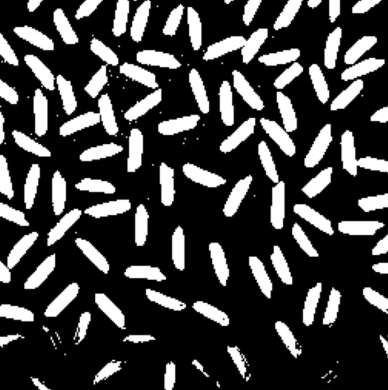

In [223]:
# Remove small white dots as noises
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

**Denoising**

After thresholding, morphological opening is applied, removing small white spots.

Shrink white spots --> erosion (open)

Expand remaining regions --> dilation (close)

3×3 neighborhood

In [224]:
#3. center of grains (elucidian_distance)
dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist, 0.35 * dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

In [225]:
# background (fully black(0))
sure_bg = cv2.dilate(opening, kernel, iterations=3)

In [226]:
unknown = cv2.subtract(sure_bg, sure_fg)

unknown=possible boundary/edge pixels between grains and background

In [227]:
# labels for the center of grains-->(num_rice)
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

In [228]:
print(f"Shape of img: {img.shape}, Dtype: {img.dtype}")
print(f"Shape of markers: {markers.shape}, Dtype: {markers.dtype}")
# Watershed (background_marker==1, unknown_marker==0, centerOfGrains_marker>=2)
markers = cv2.watershed(img, markers)
#boundaries_marker == -1

Shape of img: (256, 256, 3), Dtype: uint8
Shape of markers: (256, 256), Dtype: int32


In [229]:
#I want to set square border of image black as background (markers ==1)
markers[0,:] = 1
markers[-1,:] = 1
markers[:,0] = 1
markers[:,-1] = 1

In [230]:
unique = np.unique(markers)
# count rices except background and boundaries
num_rice = len([u for u in unique if u>1])

In [231]:
print("Number of rice grains:", num_rice)

Number of rice grains: 99


In [232]:
output = img.copy()

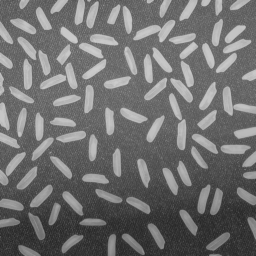

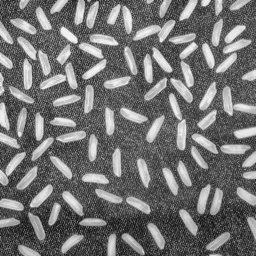

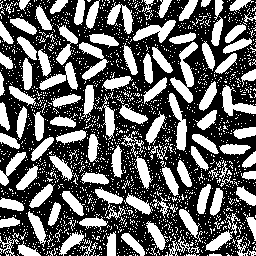

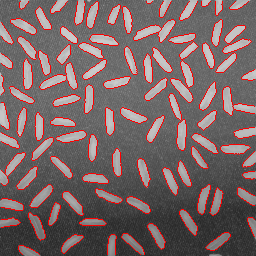

In [233]:
#red boundaries
output[markers == -1] = [0, 0, 255]

cv2_imshow(gray)
cv2_imshow(gray_eq)
cv2_imshow(thresh)
cv2_imshow(output)

In [234]:
# blank black image
colored = np.zeros_like(img)

In [235]:
# Generate random colors
rng = np.random.default_rng(42)  # seed == 42 (for reproducibility)

for label in range(2, markers.max() + 1):  # skip 0 and -1
    mask = (markers == label)

    # random pastel color
    color = rng.integers(150, 255, size=3)

    colored[mask] = color

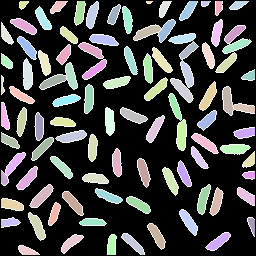

In [236]:
# set boundary of grains = white
colored[markers == -1] = [255, 255, 255]
markers[:,0] = 1
markers[:,-1] = 1
markers[0,:] = 1
markers[-1,:] = 1
cv2_imshow(colored)

If a grain contains N pixels,

1) Area=sum(N)

2) Centroid of grains:

* x(centroid) = 1/N * (x1+x2+...+xN)

x_center = np.mean(x_coords[flt]))

* y(centroid) = 1/N * (y1+y2+...+yN)

y_center = np.mean(y_coords[flt]))



In [237]:
grain_areas = []
grain_x_center = []
grain_y_center = []
H , W = markers.shape
y_coords, x_coords = np.indices((H,W))

for label in range(2, markers.max() + 1):
    flt = markers == label
    area = np.sum(flt)
    grain_areas.append(area)
    y_center = np.mean(y_coords[flt])
    grain_y_center.append(y_center)
    x_center = np.mean(x_coords[flt])
    grain_x_center.append(x_center)

In [238]:
# Sort areas from smallest to largest
grain_areas_sorted = sorted(grain_areas)

print("Number of grains detected:", len(grain_areas_sorted))
print("Smallest area:", grain_areas_sorted[0])
print("Largest area:", grain_areas_sorted[-1])
print("Mean area:", sum(grain_areas_sorted) / len(grain_areas_sorted))

print("\nAll areas sorted (small → large):")
print(grain_areas_sorted)

Number of grains detected: 99
Smallest area: 9
Largest area: 214
Mean area: 151.94949494949495

All areas sorted (small → large):
[np.int64(9), np.int64(31), np.int64(32), np.int64(43), np.int64(65), np.int64(69), np.int64(69), np.int64(76), np.int64(80), np.int64(87), np.int64(95), np.int64(96), np.int64(97), np.int64(102), np.int64(109), np.int64(109), np.int64(112), np.int64(120), np.int64(124), np.int64(127), np.int64(128), np.int64(129), np.int64(129), np.int64(130), np.int64(132), np.int64(133), np.int64(135), np.int64(138), np.int64(138), np.int64(142), np.int64(148), np.int64(148), np.int64(150), np.int64(151), np.int64(152), np.int64(153), np.int64(153), np.int64(154), np.int64(155), np.int64(156), np.int64(156), np.int64(159), np.int64(159), np.int64(160), np.int64(160), np.int64(160), np.int64(161), np.int64(161), np.int64(162), np.int64(163), np.int64(164), np.int64(165), np.int64(165), np.int64(166), np.int64(167), np.int64(167), np.int64(167), np.int64(168), np.int64(168)

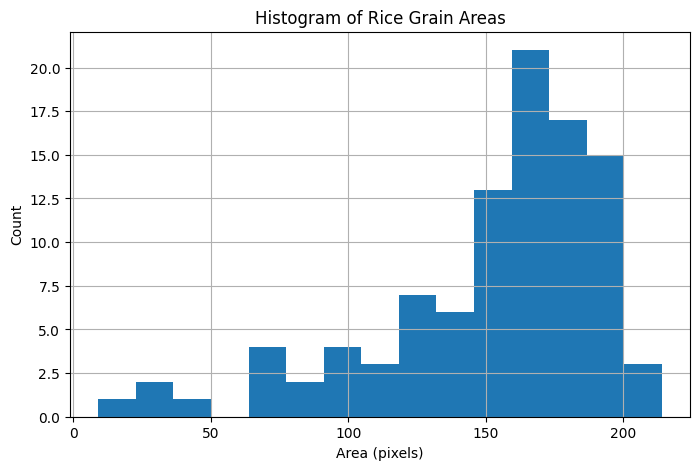

In [239]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(grain_areas_sorted, bins=15)
plt.xlabel("Area (pixels)")
plt.ylabel("Count")
plt.title("Histogram of Rice Grain Areas")
plt.grid(True)
plt.show()

 now I want to define:

 Aspect Ratio = major axis / minor axis

 * major axis = length of the longest diameter of the ellipse (grains are ellipse-like)

 * minor axis = length of the short diameter

 cv2.findContours --> detects the boundary of the grain

 cv2.fitEllipse --> finds the best-fit ellipse for the grain

 * but for broken or very small grains, the ellipse fitting (cv2.fitEllipse) often ❌ fails because it requires at least **5 points** in the contour so we use ✅ cv2.boundingRect(cnt) --> finds the smallest upright rectangle for broken or small rices.

In [240]:
aspect_ratios = []

for label in range(2, markers.max() + 1):
    mask = markers == label
    mask_uint8 = np.uint8(mask)

    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        continue

    cnt = contours[0]

    if len(cnt) >= 5:
        ellipse = cv2.fitEllipse(cnt)
        (center, (major_axis, minor_axis), angle) = ellipse

        aspect_ratio = major_axis / minor_axis
        aspect_ratios.append(aspect_ratio)
    else:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = max(w, h) / min(w, h)
        aspect_ratios.append(aspect_ratio)

In [241]:
print("Aspect Ratios (Major/Minor) of all grains:")
for i, ar in enumerate(aspect_ratios, 1):
    print(f"Grain {i}: {ar:.2f}")

Aspect Ratios (Major/Minor) of all grains:
Grain 1: 0.49
Grain 2: 0.37
Grain 3: 0.28
Grain 4: 2.50
Grain 5: 0.22
Grain 6: 0.29
Grain 7: 0.52
Grain 8: 0.48
Grain 9: 0.31
Grain 10: 0.26
Grain 11: 0.31
Grain 12: 0.26
Grain 13: 0.21
Grain 14: 0.26
Grain 15: 0.29
Grain 16: 0.24
Grain 17: 0.19
Grain 18: 0.23
Grain 19: 0.26
Grain 20: 0.30
Grain 21: 0.25
Grain 22: 0.26
Grain 23: 0.29
Grain 24: 0.22
Grain 25: 0.25
Grain 26: 0.26
Grain 27: 0.25
Grain 28: 0.30
Grain 29: 0.21
Grain 30: 0.25
Grain 31: 0.28
Grain 32: 0.36
Grain 33: 0.24
Grain 34: 0.25
Grain 35: 0.21
Grain 36: 0.25
Grain 37: 0.27
Grain 38: 0.25
Grain 39: 0.23
Grain 40: 0.25
Grain 41: 0.09
Grain 42: 0.26
Grain 43: 0.26
Grain 44: 0.28
Grain 45: 0.25
Grain 46: 0.23
Grain 47: 0.22
Grain 48: 0.29
Grain 49: 0.24
Grain 50: 0.20
Grain 51: 0.24
Grain 52: 0.22
Grain 53: 0.25
Grain 54: 0.28
Grain 55: 0.25
Grain 56: 0.41
Grain 57: 0.26
Grain 58: 0.28
Grain 59: 0.21
Grain 60: 0.27
Grain 61: 0.32
Grain 62: 0.25
Grain 63: 0.27
Grain 64: 0.28
Grain 

1) Applying colored watershed image as the background.
2) When hovering over each point, (the grain area + aspect ratio) is displayed as hover text.
3) hover mode = closest

In [242]:
import plotly.graph_objects as go
from PIL import Image

img_width = img.shape[0]
img_height = img.shape[1]
x_data = grain_x_center
# yplot​= H−ynumpy​ (H==256)
y_data = [256.0 - yy for yy in grain_y_center]
# Custom hover text for each point
hover_text = [
    f"Area: {a} px<br>Aspect Ratio: {ar:.2f}"
    for a, ar in zip(grain_areas, aspect_ratios)
]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x_data,
    y=y_data,
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8),
    hoverinfo='text',
    text=hover_text,
    name='Scatter Points'
))

In [243]:
fig.add_layout_image(
    source= Image.fromarray(colored),
    xref="x",
    yref="y",
    x=0,
    y=256,
    sizex=img_width,
    sizey=img_height,
    sizing="stretch",
    layer="above",
    opacity=0.75
)


fig.update_layout(
    xaxis=dict(range=[0, img_width], showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(range=[0, img_height], showgrid=False, zeroline=False, showticklabels=False, scaleanchor="x", scaleratio=1),
    width=img_width,
    height=img_height,
    margin=dict(l=0, r=0, t=0, b=0),
    hovermode="closest"
)

fig.show()

 i want to define bins and calculate number of grains per bin

 then Determine the total number of grains and convert counts into percentage of total grains.

 * normalized_counts = (counts / total_grains) * 100

 last step is calculate the cumulative percentage of grains up to each bin:

 * normalized_cum_counts = (np.cumsum(counts) / total_grains) * 100





In [244]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Define bins for the histogram
bins = np.arange(0, max(grain_areas) + 10, 10)

# Calculate histogram counts and bin edges
counts, bin_edges = np.histogram(grain_areas, bins=bins)

# Calculate total number of grains for normalization
total_grains = len(grain_areas)

# Calculate normalized counts (frequency in percentage)
normalized_counts = (counts / total_grains) * 100

# Calculate normalized cumulative counts (cumulative frequency in percentage)
normalized_cum_counts = (np.cumsum(counts) / total_grains) * 100

**Advantage of combining histogram and cumulative curve:**

You can see both the detailed distribution (frequency) and the cumulative distribution at the same time.

It clearly shows how the grains are distributed across the range of sizes.

In [245]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add histogram trace to primary y-axis
fig.add_trace(
    go.Bar(
        x=bin_edges[:-1], # Use left edges of bins for x-values
        y=normalized_counts,
        width=[bins[i+1] - bins[i] for i in range(len(bins)-1)], # Set bar width
        name='Histogram',
        marker_color='#330C73',
        opacity=0.75
    ),
    secondary_y=False,
)

# Add cumulative curve trace to secondary y-axis
fig.add_trace(
    go.Scatter(
        x=bin_edges[1:], # Use right edges of bins for x-values
        y=normalized_cum_counts,
        mode='lines',
        name='Cumulative Distribution',
        line=dict(color='#835CD3', width=2)
    ),
    secondary_y=True,
)

# Update layout for better readability
fig.update_layout(
    title_text='Distribution of Rice Grain Areas (Percentage)',
    xaxis_title_text='Area (pixels)',
    bargap=0.05, # Gap between bars
    bargroupgap=0.1 # Gap between groups of bars
)

# Set y-axis titles
fig.update_yaxes(title_text='Frequency (%)', secondary_y=False)
fig.update_yaxes(title_text='Cumulative Frequency (%)', secondary_y=True)

fig.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


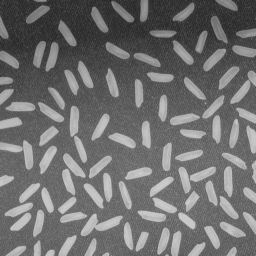

In [246]:

from google.colab import drive
drive.mount ('/content/drive')
img_path = '/content/drive/MyDrive/rotated_rice.png'
img = cv2.imread(img_path)
cv2_imshow(img)

In [247]:
img.shape

(256, 256, 3)

In [248]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [249]:
#CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
gray_eq = clahe.apply(gray)

In [250]:
#detecting grains in the bottom of image with low contrast
thresh = cv2.adaptiveThreshold(gray_eq, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY,
                               51, 2)

In [251]:
# Remove small white dots as noises
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

In [252]:
#3. center of grains (elucidian_distance)
dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist, 0.35 * dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

In [253]:
# background (fully black(0))
sure_bg = cv2.dilate(opening, kernel, iterations=3)

In [254]:
unknown = cv2.subtract(sure_bg, sure_fg)

In [255]:
# labels for the center of grains-->(num_rice)
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
# Watershed (background_marker==1, unknown_marker==0, centerOfGrains_marker>=2)
markers = cv2.watershed(img, markers)
#boundaries_marker == -1
#I want to set square border of image black as background (markers ==1)
markers[0,:] = 1
markers[-1,:] = 1
markers[:,0] = 1
markers[:,-1] = 1

In [256]:
grain_areas = []
grain_x_center = []
grain_y_center = []
H , W = markers.shape
y_coords, x_coords = np.indices((H,W))

for label in range(2, markers.max() + 1):
    flt = markers == label
    area = np.sum(flt)
    grain_areas.append(area)
    y_center = np.mean(y_coords[flt])
    grain_y_center.append(y_center)
    x_center = np.mean(x_coords[flt])
    grain_x_center.append(x_center)
# Sort areas from smallest to largest
grain_areas_sorted = sorted(grain_areas)

print("Number of grains detected:", len(grain_areas_sorted))
print("Smallest area:", grain_areas_sorted[0])
print("Largest area:", grain_areas_sorted[-1])
print("Mean area:", sum(grain_areas_sorted) / len(grain_areas_sorted))

print("\nAll areas sorted (small → large):")
print(grain_areas_sorted)

Number of grains detected: 99
Smallest area: 9
Largest area: 214
Mean area: 152.0

All areas sorted (small → large):
[np.int64(9), np.int64(31), np.int64(32), np.int64(43), np.int64(65), np.int64(69), np.int64(69), np.int64(76), np.int64(80), np.int64(87), np.int64(95), np.int64(96), np.int64(97), np.int64(102), np.int64(109), np.int64(109), np.int64(111), np.int64(120), np.int64(124), np.int64(127), np.int64(128), np.int64(129), np.int64(129), np.int64(130), np.int64(132), np.int64(135), np.int64(135), np.int64(138), np.int64(138), np.int64(142), np.int64(148), np.int64(148), np.int64(151), np.int64(151), np.int64(152), np.int64(153), np.int64(153), np.int64(154), np.int64(156), np.int64(157), np.int64(157), np.int64(159), np.int64(159), np.int64(160), np.int64(160), np.int64(160), np.int64(161), np.int64(161), np.int64(162), np.int64(163), np.int64(164), np.int64(164), np.int64(165), np.int64(166), np.int64(166), np.int64(167), np.int64(167), np.int64(168), np.int64(168), np.int64(16

In [257]:
output = img.copy()

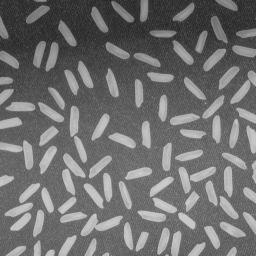

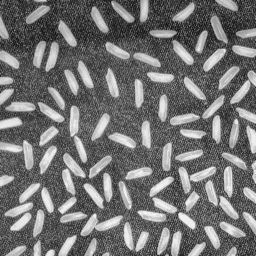

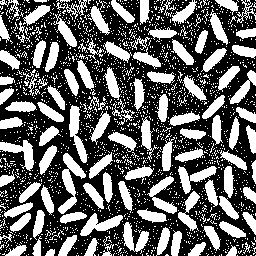

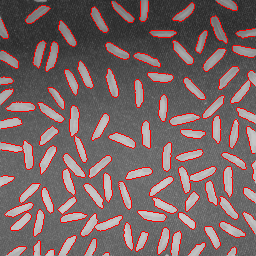

In [258]:
#red boundaries
output[markers == -1] = [0, 0, 255]

cv2_imshow(gray)
cv2_imshow(gray_eq)
cv2_imshow(thresh)
cv2_imshow(output)

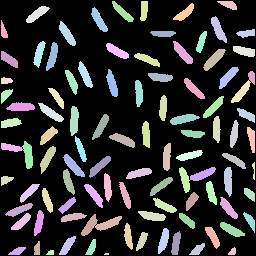

In [260]:
# blank black image
colored = np.zeros_like(img)
# Generate random colors
rng = np.random.default_rng(42)  # seed == 42 (for reproducibility)

for label in range(2, markers.max() + 1):
    mask = (markers == label)

    # random pastel color
    color = rng.integers(150, 255, size=3)

    colored[mask] = color

cv2_imshow(colored)